House Pricing Prediction - Part Two | Outliers Extraction Baseline Model | Feature Selection using Shapley Values 

# Phase One: With/Without Outliers Analysis, Getting Baseline Model

Loading Datasets

In [1]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
import lightgbm as lgbm

import numpy as np

import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
import shap


In [2]:

path = "./data/outlier-exclusion/"
with open(path + "dataset-w-outliers-new-ord-enc.json", 'r') as f:
    data_w_outliers = json.load(f)

with open(path + "dataset-wo-outliers-new-ord-enc.json", 'r') as f:
    data_wo_outliers = json.load(f)

df_w_outliers = pd.DataFrame.from_dict(data_w_outliers,orient="columns")
df_wo_outliers = pd.DataFrame.from_dict(data_wo_outliers,orient="columns")


Split dataset into training-validation set

In [3]:
X_w_outliers = df_w_outliers.drop(["SalePrice"],axis = 1)
y_w_outliers = df_w_outliers["SalePrice"]

X_wo_outliers = df_wo_outliers.drop(["SalePrice"],axis = 1)
y_wo_outliers = df_wo_outliers["SalePrice"]

test_size = 0.25
random_state = 43

X_train_w,X_valid_w,y_train_w, y_valid_w = train_test_split(X_w_outliers.to_numpy(),y_w_outliers.to_numpy(),test_size=test_size,random_state=random_state)
X_train_wo,X_valid_wo,y_train_wo, y_valid_wo = train_test_split(X_wo_outliers.to_numpy(),y_wo_outliers.to_numpy(),test_size=test_size,random_state=random_state)

y_train_w = np.log(y_train_w.reshape(-1,1))
y_valid_w = np.log(y_valid_w.reshape(-1,1))
y_train_wo = np.log(y_train_wo.reshape(-1,1))
y_valid_wo = np.log(y_valid_wo.reshape(-1,1))



Training baselines models

In [4]:
# training baselines models dataset with outliers - no normalization

n_estimators = 100
loss = "squared_error"
learning_rate = 0.1
max_depth = 4
random_state = 43
verbose = 0
alpha = 1.5
kernel = "poly"
degree = 4

tree_estimator = DecisionTreeRegressor(criterion=loss,max_depth=max_depth,random_state=random_state)

models = [
    Pipeline([('poly', PolynomialFeatures(degree=degree)),
                  ('ridge', Ridge(alpha=alpha, random_state=random_state))]),
                  SVR(kernel=kernel,degree=degree, C= alpha),
    GradientBoostingRegressor(n_estimators=n_estimators, loss=loss, learning_rate=learning_rate, max_depth=max_depth,random_state=random_state,
                              verbose=verbose),
    RandomForestRegressor(n_estimators=n_estimators,criterion=loss,max_depth=max_depth,random_state=random_state,
                          verbose=verbose),
    AdaBoostRegressor(estimator=tree_estimator,n_estimators=n_estimators,learning_rate=learning_rate,loss="square",random_state=random_state),
    xgb.XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, eta=learning_rate, subsample=0.7, colsample_bytree=0.8,
                     verbose=verbose),
    lgbm.LGBMRegressor(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators, random_state=random_state,
                       verbose=-1)
]

for model in models:
    #train model with training set
    model.fit(X_train_w,y_train_w)

    #predict output using validation set
    pred = model.predict(X_valid_w)

    #find MSE score 
    mse_score = mean_squared_error(y_valid_w,pred)
    print(f"Model : {model.__class__}, MSE score in validation set : {mse_score}")



c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Model : <class 'sklearn.pipeline.Pipeline'>, MSE score in validation set : 2014.2512812134478


c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model : <class 'sklearn.svm._classes.SVR'>, MSE score in validation set : 1229.5965094843439


c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


Model : <class 'sklearn.ensemble._gb.GradientBoostingRegressor'>, MSE score in validation set : 0.02576408336431433


c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Model : <class 'sklearn.ensemble._forest.RandomForestRegressor'>, MSE score in validation set : 0.036665072889249806


c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model : <class 'sklearn.ensemble._weight_boosting.AdaBoostRegressor'>, MSE score in validation set : 0.03398148225667936
Model : <class 'xgboost.sklearn.XGBRegressor'>, MSE score in validation set : 0.024365641899188974
Model : <class 'lightgbm.sklearn.LGBMRegressor'>, MSE score in validation set : 0.025073508745031038


c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:12:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [5]:
# training baselines models dataset without outliers - no normalization

tree_estimator = DecisionTreeRegressor(criterion=loss,max_depth=max_depth,random_state=random_state)

models = [
    Pipeline([('poly', PolynomialFeatures(degree=degree)),
                  ('ridge', Ridge(alpha=alpha, random_state=random_state))]),
                  SVR(kernel=kernel,degree=degree, C= alpha),
    GradientBoostingRegressor(n_estimators=n_estimators, loss=loss, learning_rate=learning_rate, max_depth=max_depth,random_state=random_state,
                              verbose=verbose),
    RandomForestRegressor(n_estimators=n_estimators,criterion=loss,max_depth=max_depth,random_state=random_state,
                          verbose=verbose),
    AdaBoostRegressor(estimator=tree_estimator,n_estimators=n_estimators,learning_rate=learning_rate,loss="square",random_state=random_state),
    xgb.XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, eta=learning_rate, subsample=0.7, colsample_bytree=0.8,
                     verbose=verbose),
    lgbm.LGBMRegressor(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators, random_state=random_state,
                       verbose=-1)
]

for model in models:
    #train model with training set
    model.fit(X_train_wo,y_train_wo)

    #predict output using validation set
    pred = model.predict(X_valid_wo)

    #find MSE score 
    mse_score = mean_squared_error(y_valid_wo,pred)
    print(f"Model : {model.__class__}, MSE score in validation set : {mse_score}")

c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Model : <class 'sklearn.pipeline.Pipeline'>, MSE score in validation set : 96429.37804176203


c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model : <class 'sklearn.svm._classes.SVR'>, MSE score in validation set : 1558.475229373303


c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


Model : <class 'sklearn.ensemble._gb.GradientBoostingRegressor'>, MSE score in validation set : 0.01779743339553946


c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Model : <class 'sklearn.ensemble._forest.RandomForestRegressor'>, MSE score in validation set : 0.03296769456678851


c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model : <class 'sklearn.ensemble._weight_boosting.AdaBoostRegressor'>, MSE score in validation set : 0.025164216835206848
Model : <class 'xgboost.sklearn.XGBRegressor'>, MSE score in validation set : 0.014531041081038582
Model : <class 'lightgbm.sklearn.LGBMRegressor'>, MSE score in validation set : 0.015888065608107984


c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:12:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<table>
    <thead>
        <tr>
            <th></th>
            <th colspan = 4><center>Metric: Mean Squared Error (MSE) </center></th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td ><center>ML Model</center></td>
            <td ><center>Dataset with Outliers (No Norm & New Ord Encoding)</center></td>
            <td><center>Dataset without Outliers (No Norm & New Ord Encoding)</center></td>
        </tr>
        <tr>
            <td><center>Ridge with L2 Reg</center></td>
            <td><center>14856.70</center></td>
            <td><center>161186.69</center></td>
        </tr>
        <tr>
            <td><center>SVM with L2 Reg</center></td>
            <td><center> 1229.59</center></td>
            <td><center>1558.47</center></td>
        </tr>
        <tr>
            <td><center>Gradient Boosting</center></td>
            <td><center> 0.0257</center></td>
            <td><center>0.01779</center></td>
        </tr>
        <tr>
            <td><center>Random Forest</center></td>
            <td><center>0.0366</center></td>
            <td><center>0.03296</center></td>
        </tr>
        <tr>
            <td><center>AdaBoost</center></td>
            <td><center>0.0339</center></td>
            <td><center>0.02516</center></td>
        </tr>
        <tr>
            <td><center>XGB</center></td>
            <td><center><strong>0.02436</strong></center></td>
            <td><center><strong>0.01453</strong></center></td>
        </tr>
        <tr>
            <td><center> LightGBM</center></td>
            <td><center><span style="text-decoration: underline;">0.0250</span></center></td>
            <td><center><span style="text-decoration: underline;">0.01588</span></center></td>
        </tr>
    </tbody>
</table>

Conclusion #1: Evidently, XGB and LightGBM yield the lowest MSE scores for the dataset with and without outliers.

Conclusion #2: Looking at the results from the middle column in the table (dataset without outliers) we can conclude that erasing outliers in features: LotFrontage and MasVnrArea and filling missing values with the mean of these distributions produced better performance when compared with the dataset with the outliers. 

Conclusion #3: Natural log of SalePrice yields better performance than applying standard normalization.

For future steps we are going to leverage the Dataset without Outliers & Ln(SalePrice) and will benchmark models with gradient boosting algorithms.

# Phase Two: Feature Selection & Feature Engineering

The target Dataset with no outliers includes 75 features and 1272 rows, we are intrigued to find out if some of these features are not providing any value to the model's prediction capability. Furthermore, this section will encompass two main approaches: Personal Feature Selection and Shapley values, to select a subset of features that provides enough information to make a good prediction in the validation set, as well as to generalize better.

Then we proceed to include to our datasets, relevant feature engineering procedures found from other Kaggle competitors.

The main goal is to find any improvement from models' MSE from Stage One.

## Personal Feature Selection approach

This section entails the most relevant features according to personal criteria (possible bias). The aim purpose for this selection is to be compared with techniques used in interpretable AI frameworks.

In [6]:
fs_personal = ["MSSubClass", "MSZoning_enc", "LotArea", "LandContour_enc", "LotConfig_enc", "Neighborhood_enc","Condition1_enc", 
               "Condition2_enc", 
               "BldgType_enc",
               "OverallQual","OverallCond","YearBuilt","YearRemodAdd", "RoofStyle_enc", "Exterior1st_enc", "Exterior2nd_enc", 
               "MasVnrType_enc",
               "MasVnrArea", "ExterCond_enc", "BsmtQual_enc","BsmtCond_enc", "BsmtFinType1_enc", "TotalBsmtSF", "CentralAir_enc",
                 "HeatingQC_enc", "Electrical_enc",
               "1stFlrSF", "2ndFlrSF", "GrLivArea", "BsmtFullBath","TotRmsAbvGrd","Functional_enc", "KitchenQual_enc", "FireplaceQu_enc", 
               "GarageQual_enc",
                 "OpenPorchSF", "EnclosedPorch", "YrSold", "SaleCondition_enc", "SaleType_enc"]

df_fs_personal = df_wo_outliers.copy()
df_fs_personal = df_fs_personal[fs_personal]

## Shapley values approach

This section involves computing the SHAP values for each feature in order to find which ones contribute the most to the **SalePrice** predictions. The strategy is to plot these values and construct 5 subset dataframes with different feature number ranges, next step will be to put them to test to find if we can improve baseline performance.

In [7]:
X_shap_df_feat_sel = df_wo_outliers.drop(["SalePrice"],axis = 1).to_numpy()
y_shap_df_feat_sel= df_wo_outliers["SalePrice"].to_numpy()

y_train_shap = np.log(y_shap_df_feat_sel.reshape(-1,1))

c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:12:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


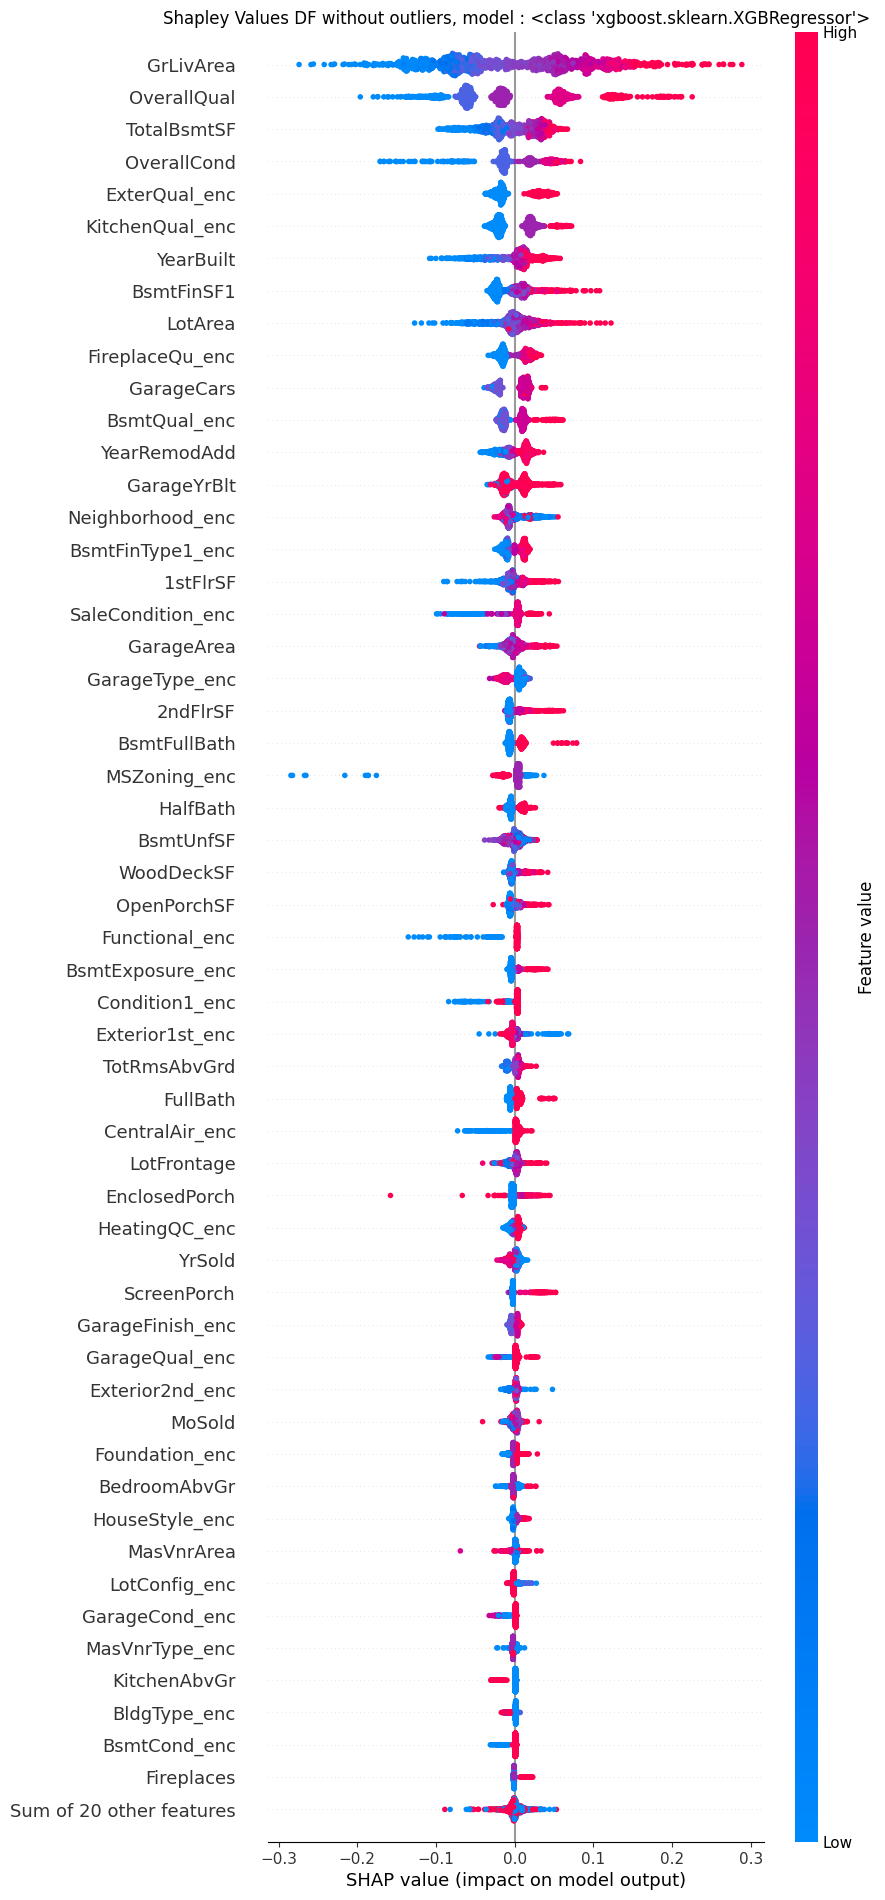

In [8]:
# Train XGBRegressor
best_params_xgb = {
    "n_estimators" : 1100,
    "eta" : 0.05,
    "booster" : "gbtree",
    "max_depth" : 3,
    "min_child_weight" : 1,
    "gamma" : 0.001,
    "subsample" : 0.5,
    "colsample_bytree" : 0.5,
    "lambda" : 1,
    "alpha" : 0,
    "seed" : random_state,
    "verbose" : verbose
}

model_shap = xgb.XGBRegressor(**best_params_xgb)
model_shap.fit(X_shap_df_feat_sel,y_train_shap)
# explain the model's predictions using SHAP
explainer = shap.Explainer(model_shap,seed=random_state)


explanation = shap.Explanation(
    values=explainer(X_shap_df_feat_sel), 
    feature_names=df_wo_outliers.drop(["SalePrice"],axis = 1).columns
)

shap.plots.beeswarm(explanation,max_display=55,show=False)
plt.title(f"Shapley Values DF without outliers, model : {model_shap.__class__}")
plt.show()

Analysis: <br>

1. High values for **GrLivArea** highly contributes on higher saleprice predictions, meanwhile lower feature values results in decreased saleprice prediction outputs.
2. High **OverallQual** values produce higher prediction output values, contrary, lower values produce lower saleprice values.
3. From the lower portion of the plot, we can infer that from features kitchenAbvGr to Fireplaces, most of the concentration of examples lie within zero, meaning that these features do not provide a meaningful contribution to the output prediction.

Conclusion: Based on the previous Beaswarm plot and carefully analyzing the results. We are going to construct 5 dataframes with the following features:
Note: We are going to specify feature ranges and the corresponding values will be in accordance to the beaswarm plot.

1. Shapley Feature Selection 1: Features -> **GrLivArea - FireplaceQu_enc**
2. Shapley Feature Selection 2: Features -> **GrLivArea - 1stFlrSF**
3. Shapley Feature Selection 3: Features -> **GrLivArea - OpenPorchSF**
4. Shapley Feature Selection 4: Features -> **GrLivArea - YrSold**
5. Shapley Feature Selection 4: Features -> **GrLivArea - MasVnrType_enc**

In [9]:
shap_1_df_wo_outliers = df_wo_outliers.copy()
shap_2_df_wo_outliers = df_wo_outliers.copy()
shap_3_df_wo_outliers = df_wo_outliers.copy()
shap_4_df_wo_outliers = df_wo_outliers.copy()
shap_5_df_wo_outliers = df_wo_outliers.copy()

shap_feat_1_names = ["GrLivArea","OverallQual","TotalBsmtSF","OverallCond","ExterQual_enc","KitchenQual_enc","YearBuilt","BsmtFinSF1","LotArea",
                     "FireplaceQu_enc" ]
shap_1_df_wo_outliers = pd.concat([shap_1_df_wo_outliers[shap_feat_1_names], shap_1_df_wo_outliers["SalePrice"]],axis=1)

shap_feat_2_names = ["GarageCars","BsmtQual_enc","YearRemodAdd","GarageYrBlt","Neighborhood_enc","BsmtFinType1_enc", "1stFlrSF"]
shap_2_df_wo_outliers = pd.concat([shap_2_df_wo_outliers[shap_feat_1_names + shap_feat_2_names], shap_2_df_wo_outliers["SalePrice"]],axis=1)

shap_feat_3_names = ["SaleCondition_enc","GarageArea","GarageType_enc","2ndFlrSF","BsmtFullBath", "MSZoning_enc", "HalfBath",
                     "BsmtUnfSF","WoodDeckSF","OpenPorchSF"]
shap_3_df_wo_outliers = pd.concat([shap_3_df_wo_outliers[shap_feat_1_names + shap_feat_2_names + shap_feat_3_names], shap_3_df_wo_outliers["SalePrice"]],axis=1)


shap_feat_4_names = ["Functional_enc","BsmtExposure_enc","Condition1_enc","Exterior1st_enc","TotRmsAbvGrd","FullBath","CentralAir_enc",
                     "LotFrontage","EnclosedPorch","HeatingQC_enc","YrSold"]
shap_4_df_wo_outliers = pd.concat([shap_4_df_wo_outliers[shap_feat_1_names + shap_feat_2_names + shap_feat_3_names +
                                                         shap_feat_4_names], shap_4_df_wo_outliers["SalePrice"]],axis=1)

shap_feat_5_names = ["ScreenPorch","GarageFinish_enc","GarageQual_enc","Exterior2nd_enc","MoSold","Foundation_enc","BedroomAbvGr",
                     "HouseStyle_enc","MasVnrArea","LotConfig_enc","GarageCond_enc","MasVnrType_enc"]
shap_5_df_wo_outliers = pd.concat([shap_5_df_wo_outliers[shap_feat_1_names + shap_feat_2_names + shap_feat_3_names +
                                                         shap_feat_4_names + shap_feat_5_names], shap_5_df_wo_outliers["SalePrice"]],axis=1)

## Feature Engineering using the DataFrame Without Outliers Dataset

In [10]:
df_wo_outliers_fe = df_wo_outliers.copy()

In [11]:
df_wo_outliers_fe['YrBltAndRemod']=df_wo_outliers_fe['YearBuilt']+df_wo_outliers_fe['YearRemodAdd']

df_wo_outliers_fe['TotalSF']=df_wo_outliers_fe['TotalBsmtSF'] + df_wo_outliers_fe['1stFlrSF'] + df_wo_outliers_fe['2ndFlrSF']

df_wo_outliers_fe['Total_sqr_footage'] = (df_wo_outliers_fe['BsmtFinSF1'] + #df_wo_outliers_fe['BsmtFinSF2'] +
                                 df_wo_outliers_fe['1stFlrSF'] + df_wo_outliers_fe['2ndFlrSF'])

df_wo_outliers_fe['Total_Bathrooms'] = (df_wo_outliers_fe['FullBath'] + (0.5 * df_wo_outliers_fe['HalfBath']) +
                               df_wo_outliers_fe['BsmtFullBath']) #+ (0.5 * df_wo_outliers_fe['BsmtHalfBath']))

df_wo_outliers_fe['Total_porch_sf'] = (df_wo_outliers_fe['OpenPorchSF'] + #df_wo_outliers_fe['3SsnPorch'] +
                              df_wo_outliers_fe['EnclosedPorch'] + df_wo_outliers_fe['ScreenPorch'] +
                              df_wo_outliers_fe['WoodDeckSF'])


df_wo_outliers_fe.drop(["YearBuilt",'YearRemodAdd','TotalBsmtSF','1stFlrSF','2ndFlrSF',
                          'BsmtFinSF1','BsmtFinSF2', 'FullBath','HalfBath', 'BsmtFullBath','BsmtHalfBath',
                              'OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch' , 'WoodDeckSF'],axis= 1,errors="ignore", inplace=True)


In [12]:
df_wo_outliers_fe_2 = df_wo_outliers.copy()

In [13]:
df_wo_outliers_fe_2['YrBltAndRemod']=df_wo_outliers_fe_2['YearBuilt']+df_wo_outliers_fe_2['YearRemodAdd']

df_wo_outliers_fe_2['TotalSF']=df_wo_outliers_fe_2['TotalBsmtSF'] + df_wo_outliers_fe_2['1stFlrSF'] + df_wo_outliers_fe_2['2ndFlrSF']

df_wo_outliers_fe_2['Total_sqr_footage'] = (df_wo_outliers_fe_2['BsmtFinSF1'] +# df_wo_outliers_fe_2['BsmtFinSF2'] +
                                 df_wo_outliers_fe_2['1stFlrSF'] + df_wo_outliers_fe_2['2ndFlrSF'])

df_wo_outliers_fe_2['Total_Bathrooms'] = (df_wo_outliers_fe_2['FullBath'] + (0.5 * df_wo_outliers_fe_2['HalfBath']) +
                               df_wo_outliers_fe_2['BsmtFullBath']) #+ (0.5 * df_wo_outliers_fe_2['BsmtHalfBath']))

df_wo_outliers_fe_2['Total_porch_sf'] = (df_wo_outliers_fe_2['OpenPorchSF'] + #df_wo_outliers_fe_2['3SsnPorch'] +
                              df_wo_outliers_fe_2['EnclosedPorch'] + df_wo_outliers_fe_2['ScreenPorch'] +
                              df_wo_outliers_fe_2['WoodDeckSF'])



# simplified features

df_wo_outliers_fe_2['has2ndfloor'] = df_wo_outliers_fe_2['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
df_wo_outliers_fe_2['hasgarage'] = df_wo_outliers_fe_2['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
df_wo_outliers_fe_2['hasbsmt'] = df_wo_outliers_fe_2['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
df_wo_outliers_fe_2['hasfireplace'] = df_wo_outliers_fe_2['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

df_wo_outliers_fe_2.drop(["YearBuilt",'YearRemodAdd','TotalBsmtSF','1stFlrSF','2ndFlrSF',
                          'BsmtFinSF1','BsmtFinSF2', 'FullBath','HalfBath', 'BsmtFullBath','BsmtHalfBath',
                              'OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch' , 'WoodDeckSF',
                              'GarageArea',"Fireplaces"],axis= 1, inplace=True)

# Feature Selection Dataframe Models Benchmark

In [14]:
best_params_xgb = {
    "n_estimators" : 1100,
    "eta" : 0.05,
    "booster" : "gbtree",
    "max_depth" : 3,
    "min_child_weight" : 1,
    "gamma" : 0.001,
    "subsample" : 0.5,
    "colsample_bytree" : 0.5,
    "lambda" : 1,
    "alpha" : 0,
    "seed" : random_state,
    "verbose" : verbose
}

best_params_lgbm = {
    "n_estimators" : 1100,
    "learning_rate" : 0.05,
    "boosting_type" : "gbdt",
    "max_depth" : 3,
    "min_child_weight" : 1,
    "subsample" : 0.5,
    "reg_lambda" : 1,
    "reg_alpha" : 0,
    "random_state" : random_state,
    "verbose" : -1
}

In [15]:
#Dataframe processing - Personal Feature Selection

X_personal_df = df_fs_personal
y_personal_df = df_wo_outliers["SalePrice"]

X_train_personal,X_valid_personal,y_train_personal, y_valid_personal = train_test_split(
    X_personal_df.to_numpy(),y_personal_df.to_numpy(),test_size=test_size,random_state=random_state)

y_train_personal = np.log(y_train_personal.reshape(-1,1))
y_valid_personal = np.log(y_valid_personal.reshape(-1,1))


models = {
    "XGB_personal" : [xgb.XGBRegressor(**best_params_xgb),
                     X_train_personal,y_train_personal,X_valid_personal,y_valid_personal],
    "LGBM_personal" : [lgbm.LGBMRegressor(**best_params_lgbm),
                       X_train_personal,y_train_personal,X_valid_personal,y_valid_personal],

}

for model_name,model_tup in models.items():
    #train model with training set
    model_tup[0].fit(model_tup[1],model_tup[2])

    #predict output using validation set
    pred = model_tup[0].predict(model_tup[3])

    #find MSE score 
    mse_score = mean_squared_error(model_tup[4],pred)
    print(f"Model : {model_name}, MSE score in validation set : {mse_score}")

c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:12:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model : XGB_personal, MSE score in validation set : 0.013258238392406444
Model : LGBM_personal, MSE score in validation set : 0.016031468330051302


c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [16]:
# Dataframes processing - Shapley Feature Selection

X_shap_df_1 = shap_1_df_wo_outliers.drop(["SalePrice"],axis = 1)
y_shap_df_1 = shap_1_df_wo_outliers["SalePrice"]
X_shap_df_2 = shap_2_df_wo_outliers.drop(["SalePrice"],axis = 1)
y_shap_df_2 = shap_2_df_wo_outliers["SalePrice"]
X_shap_df_3 = shap_3_df_wo_outliers.drop(["SalePrice"],axis = 1)
y_shap_df_3 = shap_3_df_wo_outliers["SalePrice"]
X_shap_df_4 = shap_4_df_wo_outliers.drop(["SalePrice"],axis = 1)
y_shap_df_4 = shap_4_df_wo_outliers["SalePrice"]
X_shap_df_5 = shap_5_df_wo_outliers.drop(["SalePrice"],axis = 1)
y_shap_df_5 = shap_5_df_wo_outliers["SalePrice"]

X_train_shap_1,X_valid_shap_1,y_train_shap_1, y_valid_shap_1 = train_test_split(
    X_shap_df_1.to_numpy(),y_shap_df_1.to_numpy(),test_size=test_size,random_state=random_state)
X_train_shap_2,X_valid_shap_2,y_train_shap_2, y_valid_shap_2 = train_test_split(
    X_shap_df_2.to_numpy(),y_shap_df_2.to_numpy(),test_size=test_size,random_state=random_state)
X_train_shap_3,X_valid_shap_3,y_train_shap_3, y_valid_shap_3 = train_test_split(
    X_shap_df_3.to_numpy(),y_shap_df_3.to_numpy(),test_size=test_size,random_state=random_state)
X_train_shap_4,X_valid_shap_4,y_train_shap_4, y_valid_shap_4 = train_test_split(
    X_shap_df_4.to_numpy(),y_shap_df_4.to_numpy(),test_size=test_size,random_state=random_state)
X_train_shap_5,X_valid_shap_5,y_train_shap_5, y_valid_shap_5 = train_test_split(
    X_shap_df_5.to_numpy(),y_shap_df_5.to_numpy(),test_size=test_size,random_state=random_state)


y_train_shap_1 = np.log(y_train_shap_1.reshape(-1,1))
y_valid_shap_1 = np.log(y_valid_shap_1.reshape(-1,1))
y_train_shap_2 = np.log(y_train_shap_2.reshape(-1,1))
y_valid_shap_2 = np.log(y_valid_shap_2.reshape(-1,1))
y_train_shap_3 = np.log(y_train_shap_3.reshape(-1,1))
y_valid_shap_3 = np.log(y_valid_shap_3.reshape(-1,1))
y_train_shap_4 = np.log(y_train_shap_4.reshape(-1,1))
y_valid_shap_4 = np.log(y_valid_shap_4.reshape(-1,1))
y_train_shap_5 = np.log(y_train_shap_5.reshape(-1,1))
y_valid_shap_5 = np.log(y_valid_shap_5.reshape(-1,1))







In [17]:
#Shapley Feature Selection Model Training

models = {
    "XGB_shap_1" : [xgb.XGBRegressor(**best_params_xgb),
                     X_train_shap_1,y_train_shap_1,X_valid_shap_1,y_valid_shap_1],
    "LGBM_shap_1" : [lgbm.LGBMRegressor(**best_params_lgbm),
                       X_train_shap_1,y_train_shap_1,X_valid_shap_1,y_valid_shap_1],
    "XGB_shap_2" : [xgb.XGBRegressor(**best_params_xgb),
                     X_train_shap_2,y_train_shap_2,X_valid_shap_2,y_valid_shap_2],
    "LGBM_shap_2" : [lgbm.LGBMRegressor(**best_params_lgbm),
                       X_train_shap_2,y_train_shap_2,X_valid_shap_2,y_valid_shap_2],
    "XGB_shap_3" : [xgb.XGBRegressor(**best_params_xgb),
                     X_train_shap_3,y_train_shap_3,X_valid_shap_3,y_valid_shap_3],
    "LGBM_shap_3" : [lgbm.LGBMRegressor(**best_params_lgbm),
                       X_train_shap_3,y_train_shap_3,X_valid_shap_3,y_valid_shap_3],
    "XGB_shap_4" : [xgb.XGBRegressor(**best_params_xgb),
                     X_train_shap_4,y_train_shap_4,X_valid_shap_4,y_valid_shap_4],
    "LGBM_shap_4" : [lgbm.LGBMRegressor(**best_params_lgbm),
                       X_train_shap_4,y_train_shap_4,X_valid_shap_4,y_valid_shap_4],
    "XGB_shap_5" : [xgb.XGBRegressor(**best_params_xgb),
                     X_train_shap_5,y_train_shap_5,X_valid_shap_5,y_valid_shap_5],
    "LGBM_shap_5" : [lgbm.LGBMRegressor(**best_params_lgbm),
                       X_train_shap_5,y_train_shap_5,X_valid_shap_5,y_valid_shap_5]
}

for model_name,model_tup in models.items():
    #train model with training set
    model_tup[0].fit(model_tup[1],model_tup[2])

    #predict output using validation set
    pred = model_tup[0].predict(model_tup[3])

    #find MSE score 
    mse_score = mean_squared_error(model_tup[4],pred)
    print(f"Model : {model_name}, MSE score in validation set : {mse_score}")

c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:12:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model : XGB_shap_1, MSE score in validation set : 0.017222193554696046
Model : LGBM_shap_1, MSE score in validation set : 0.01771935208322757


c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:12:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model : XGB_shap_2, MSE score in validation set : 0.016463987324920847
Model : LGBM_shap_2, MSE score in validation set : 0.01654186417402713


c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:12:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model : XGB_shap_3, MSE score in validation set : 0.014207410238447387
Model : LGBM_shap_3, MSE score in validation set : 0.016073433034940805


c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:12:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model : XGB_shap_4, MSE score in validation set : 0.013249868714412097
Model : LGBM_shap_4, MSE score in validation set : 0.01580497173717275


c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:12:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model : XGB_shap_5, MSE score in validation set : 0.013065656503850068
Model : LGBM_shap_5, MSE score in validation set : 0.014843256438817795


c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [18]:
#Dataframe processing - Feature Engineering 1

X_fe = df_wo_outliers_fe.drop(["SalePrice"],axis=1)
y_fe = df_wo_outliers_fe["SalePrice"]

X_train_fe,X_valid_fe,y_train_fe, y_valid_fe = train_test_split(
    X_fe.to_numpy(),y_fe.to_numpy(),test_size=test_size,random_state=random_state)

y_train_fe = np.log1p(y_train_fe.reshape(-1,1))
y_valid_fe = np.log1p(y_valid_fe.reshape(-1,1))


models = {
    "XGB_fe" : [xgb.XGBRegressor(**best_params_xgb),
                     X_train_fe,y_train_fe,X_valid_fe,y_valid_fe],
    "LGBM_fe" : [lgbm.LGBMRegressor(**best_params_lgbm),
                       X_train_fe,y_train_fe,X_valid_fe,y_valid_fe],

}

for model_name,model_tup in models.items():
    #train model with training set
    model_tup[0].fit(model_tup[1],model_tup[2])

    #predict output using validation set
    pred = model_tup[0].predict(model_tup[3])

    #find MSE score 
    mse_score = mean_squared_error(model_tup[4],pred)
    print(f"Model : {model_name}, MSE score in validation set : {mse_score}")

c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:12:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model : XGB_fe, MSE score in validation set : 0.011750543125985422
Model : LGBM_fe, MSE score in validation set : 0.01440770947230856


c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [19]:
#Dataframe processing - Feature Engineering 2

X_fe_2 = df_wo_outliers_fe_2.drop(["SalePrice"],axis=1)
y_fe_2 = df_wo_outliers_fe_2["SalePrice"]

X_train_fe_2,X_valid_fe_2,y_train_fe_2, y_valid_fe_2 = train_test_split(
    X_fe_2.to_numpy(),y_fe_2.to_numpy(),test_size=test_size,random_state=random_state)

y_train_fe_2 = np.log1p(y_train_fe_2.reshape(-1,1))
y_valid_fe_2 = np.log1p(y_valid_fe_2.reshape(-1,1))


models = {
    "XGB_fe_2" : [xgb.XGBRegressor(**best_params_xgb),
                     X_train_fe_2,y_train_fe_2,X_valid_fe_2,y_valid_fe_2],
    "LGBM_fe_2" : [lgbm.LGBMRegressor(**best_params_lgbm),
                       X_train_fe_2,y_train_fe_2,X_valid_fe_2,y_valid_fe_2],

}

for model_name,model_tup in models.items():
    #train model with training set
    model_tup[0].fit(model_tup[1],model_tup[2])

    #predict output using validation set
    pred = model_tup[0].predict(model_tup[3])

    #find MSE score 
    mse_score = mean_squared_error(model_tup[4],pred)
    print(f"Model : {model_name}, MSE score in validation set : {mse_score}")

c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:12:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model : XGB_fe_2, MSE score in validation set : 0.011873097080567266
Model : LGBM_fe_2, MSE score in validation set : 0.014069668655092807


c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<table>
    <thead>
        <tr>
            <th></th>
            <th colspan = 2><center>Metric: Mean Squared Error (MSE) </center></th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td ><center>ML Model</center></td>
            <td ><center>XGBRegressor</center></td>
            <td><center>LightGBMRegressor</center></td>
        </tr>
        <tr>
            <td><center>Baseline Dataset wo outliers (No Norm & Ord Cat Enc)</center></td>
            <td><center>0.01453</center></td>
            <td><center>0.01588</center></td>
        </tr>
        <tr>
            <td><center>Personal</center></td>
            <td><center>0.01325</center></td>
            <td><center>0.01603</center></td>
        </tr>
        <tr>
            <td><center>Shap Model 1</center></td>
            <td><center>0.01722</center></td>
            <td><center>0.01771</center></td>
        </tr>
        <tr>
            <td><center>Shap Model 2</center></td>
            <td><center>0.01646</center></td>
            <td><center>0.01654</center></td>
        </tr>
        <tr>
            <td><center>Shap Model 3</center></td>
            <td><center>0.01420</center></td>
            <td><center>0.01607</center></td>
        </tr>
        <tr>
            <td><center>Shap Model 4</center></td>
            <td><center>0.01324</center></td>
            <td><center>0.01580</center></td>
        </tr>
        <tr>
            <td><center>Shap Model 5</center></td>
            <td><center>0.013065</center></td>
            <td><center>0.01484</center></td>
        </tr>
        <tr>
            <td><center>FE 1</center></td>
            <td><center><strong>0.01175</strong></center></td>
            <td><center><strong>0.01440</strong></center></td>
        </tr>
        <tr>
            <td><center>FE 2</center></td>
            <td><center><span style="text-decoration: underline;">0.01208</span></center></td>
            <td><center><span style="text-decoration: underline;">0.01459</span></center></td>
        </tr>
    </tbody>
</table>

Conclusion: Incorporating Feature Engineered variables as work from other competitors has demonstrated an increase in performance. Apparently, incorporating similar context numeric variables (FE 1) yielded better performance than including those features plus reducing the number of categories in a subset of certain variables ( FE 2).

# Saving selected Dataframes to JSON Files

In [20]:
save_path = "./data/feature-selection/"

df_wo_outliers_fe.to_json(save_path + "dataset-wo-fe-2-new-ord-enc.json",orient="columns")